<a href="https://colab.research.google.com/github/anujott-codes/Credit-Loan-Approval/blob/main/Credit_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [55]:
!pip install sdv

In [56]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

import warnings
warnings.filterwarnings('ignore')

##Credit Card Approval

###import dataset

In [57]:
#using credit dataset from kaggle derived from UCI
credit_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project/Credit Card and Loan Approval/credit_approval_dataset.csv")
credit_df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


###Generating Synthetic Data

In [58]:
# --- Configuration ---
INPUT_FILE = "clean_dataset.csv"
OUTPUT_FILE = "ctgan_synthetic_credit_data_5000.csv"
N_SAMPLES = 1000
N_EPOCHS = 500

# 1. Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project/Credit Card and Loan Approval/credit_approval_dataset.csv")

# 2. Define Metadata
# Metadata is crucial: it tells the model which columns are discrete, continuous, etc.
metadata = SingleTableMetadata()
# Automatically infer the initial data types (sdtypes)
metadata.detect_from_dataframe(data=df)

# IMPORTANT: Manually adjust discrete/categorical columns for better CTGAN performance
# Binary/discrete integer columns should be explicitly marked as 'categorical'.
categorical_columns = [
    'Gender', 'Married', 'BankCustomer', 'PriorDefault',
    'Employed', 'DriversLicense', 'Approved', 'CreditScore', 'ZipCode'
]
for col in categorical_columns:
    if col in df.columns:
        # Update the metadata to ensure the model treats these as distinct categories, not ordinal numbers
        metadata.update_column(column_name=col, sdtype='categorical')

# 3. Instantiate the CTGAN Synthesizer
# This is the Generative Adversarial Network specialized for tabular data.
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    # Adjust hyperparameters for better results
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=N_EPOCHS
)

# 4. Train the Model (This may take several minutes)
print(f"Starting CTGAN training for {N_EPOCHS} epochs...")
synthesizer.fit(df)
print("Training complete.")

# 5. Generate Synthetic Data
print(f"Generating {N_SAMPLES} synthetic records...")
synthetic_data = synthesizer.sample(num_rows=N_SAMPLES)

# 6. Save the Result
synthetic_data.to_csv(OUTPUT_FILE, index=False)
print(f"Successfully generated and saved {N_SAMPLES} records to {OUTPUT_FILE}")

# 7. Quick Validation Check
print("\n--- Validation Check ---")
print("Original Data Shape:", df.shape)
print("Synthetic Data Shape:", synthetic_data.shape)
print("Synthetic Data Head:")
print(synthetic_data.head())

Starting CTGAN training for 500 epochs...
Training complete.
Generating 1000 synthetic records...
Successfully generated and saved 1000 records to ctgan_synthetic_credit_data_5000.csv

--- Validation Check ---
Original Data Shape: (690, 16)
Synthetic Data Shape: (1000, 16)
Synthetic Data Head:
   Gender        Age       Debt  Married  BankCustomer               Industry  \
0       0  25.138509   1.350365        1             1                 Energy   
1       0  20.531542  16.619451        0             0  ConsumerDiscretionary   
2       1  16.704173  21.386543        0             1              Materials   
3       0  13.750000   0.629934        1             1                 Energy   
4       0  69.799746   2.724225        1             0             Financials   

  Ethnicity  YearsEmployed  PriorDefault  Employed  CreditScore  \
0     White       1.199495             1         1            3   
1     White      22.599791             0         0            0   
2     White      

In [59]:
#checking null value
synthetic_data.isna().sum()

,0
Gender,0
Age,0
Debt,0
Married,0
BankCustomer,0
Industry,0
Ethnicity,0
YearsEmployed,0
PriorDefault,0
Employed,0


In [60]:
#checking duplicates
synthetic_data.duplicated().sum()

np.int64(0)

In [61]:
#description of synthetic data
synthetic_data.describe()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Approved
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.710000,32.714021,3.563927,0.716000,0.80800,1.973377,0.496000,0.384000,2.365000,0.375000,171.925000,792.738000,0.260000
std,0.453989,14.728363,4.755253,0.451162,0.39407,3.184534,0.500234,0.486601,5.379658,0.484365,174.252625,4829.769266,0.438854
min,0.000000,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.542112,0.904820,0.000000,1.00000,0.517332,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000
50%,1.000000,28.700267,2.120624,1.000000,1.00000,0.979666,0.000000,0.000000,0.000000,0.000000,144.000000,138.500000,0.000000
75%,1.000000,40.675710,3.664407,1.000000,1.00000,1.450199,1.000000,1.000000,3.000000,1.000000,240.000000,541.250000,1.000000
max,1.000000,80.250000,28.000000,1.000000,1.00000,26.329384,1.000000,1.000000,67.000000,1.000000,2000.000000,100000.000000,1.000000


In [62]:
#concatenating synthetic data into final dataset
credit_df = pd.concat((credit_df,synthetic_data), ignore_index=True)
credit_df

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.830000,0.000000,1,1,Industrials,White,1.250000,1,1,1,0,ByBirth,202,0,1
1,0,58.670000,4.460000,1,1,Materials,Black,3.040000,1,1,6,0,ByBirth,43,560,1
2,0,24.500000,0.500000,1,1,Materials,Black,1.500000,1,0,0,0,ByBirth,280,824,1
3,1,27.830000,1.540000,1,1,Industrials,White,3.750000,1,1,5,1,ByBirth,100,3,1
4,1,20.170000,5.625000,1,1,Industrials,White,1.710000,1,0,0,0,ByOtherMeans,120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,0,21.571491,2.464747,1,1,Financials,Latino,1.019038,0,0,0,0,ByBirth,160,328,1
1686,1,41.891312,2.084498,1,1,Financials,White,2.450659,1,0,0,0,ByBirth,160,68,1
1687,1,49.609221,2.631383,1,1,Industrials,Black,1.119332,1,0,14,0,ByBirth,350,928,0
1688,0,50.054820,0.000000,0,1,Energy,Black,0.419006,1,1,0,1,ByBirth,80,0,0


In [63]:
credit_df.to_csv('Final_credit_data.csv')

###EDA

In [64]:
#info regarding dataset
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          1690 non-null   int64  
 1   Age             1690 non-null   float64
 2   Debt            1690 non-null   float64
 3   Married         1690 non-null   int64  
 4   BankCustomer    1690 non-null   int64  
 5   Industry        1690 non-null   object 
 6   Ethnicity       1690 non-null   object 
 7   YearsEmployed   1690 non-null   float64
 8   PriorDefault    1690 non-null   int64  
 9   Employed        1690 non-null   int64  
 10  CreditScore     1690 non-null   int64  
 11  DriversLicense  1690 non-null   int64  
 12  Citizen         1690 non-null   object 
 13  ZipCode         1690 non-null   int64  
 14  Income          1690 non-null   int64  
 15  Approved        1690 non-null   int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 211.4+ KB


In [65]:
#check null values
credit_df.isna().sum()

,0
Gender,0
Age,0
Debt,0
Married,0
BankCustomer,0
Industry,0
Ethnicity,0
YearsEmployed,0
PriorDefault,0
Employed,0


In [66]:
#check duplicates
credit_df.duplicated().sum()

np.int64(0)

In [67]:
#unique values per column
credit_df.nunique()

,0
Gender,2
Age,1298
Debt,1100
Married,2
BankCustomer,2
Industry,14
Ethnicity,5
YearsEmployed,1065
PriorDefault,2
Employed,2


In [68]:
#description of the dataset
credit_df.describe()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Approved
count,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000,1690.000000
mean,0.704142,32.224119,4.051744,0.734320,0.789941,2.075460,0.507101,0.401775,2.379290,0.408876,175.445562,884.457988,0.335503
std,0.456563,13.639485,4.881517,0.441826,0.407471,3.252985,0.500098,0.490402,5.173478,0.491772,174.137508,4988.261571,0.472306
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.080435,0.939077,0.000000,1.000000,0.349011,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000
50%,1.000000,28.576583,2.294163,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,150.000000,41.500000,0.000000
75%,1.000000,39.241307,5.002987,1.000000,1.000000,2.250000,1.000000,1.000000,3.000000,1.000000,260.000000,500.000000,1.000000
max,1.000000,80.250000,28.000000,1.000000,1.000000,28.500000,1.000000,1.000000,67.000000,1.000000,2000.000000,100000.000000,1.000000


In [69]:
#unique industries
credit_df['Industry'].unique()

array(['Industrials', 'Materials', 'CommunicationServices', 'Transport',
       'InformationTechnology', 'Financials', 'Energy', 'Real Estate',
       'Utilities', 'ConsumerDiscretionary', 'Education',
       'ConsumerStaples', 'Healthcare', 'Research'], dtype=object)

In [70]:
credit_df['Citizen'].unique()

array(['ByBirth', 'ByOtherMeans', 'Temporary'], dtype=object)

In [71]:
#extracting numerical features and categorical features
num_features = credit_df.select_dtypes(exclude='O').columns.to_list()
cat_features = credit_df.select_dtypes(include='O').columns.to_list()

print("----- Numerical Features -----")
print(num_features)
print(f"Total : {len(num_features)}")
print("\n")
print("----- Categorical Features -----")
print(cat_features)
print(f"Total : {len(cat_features)}")

----- Numerical Features -----
['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'ZipCode', 'Income', 'Approved']
Total : 13


----- Categorical Features -----
['Industry', 'Ethnicity', 'Citizen']
Total : 3


In [72]:
#function to plot distributions
def plot(df, col ,num):
  plt.subplot(4,4,num)
  sns.histplot(data = df,x=col,kde=True, color='skyblue')
  plt.title(f"{col} Distribution")
  plt.xlabel(" ")

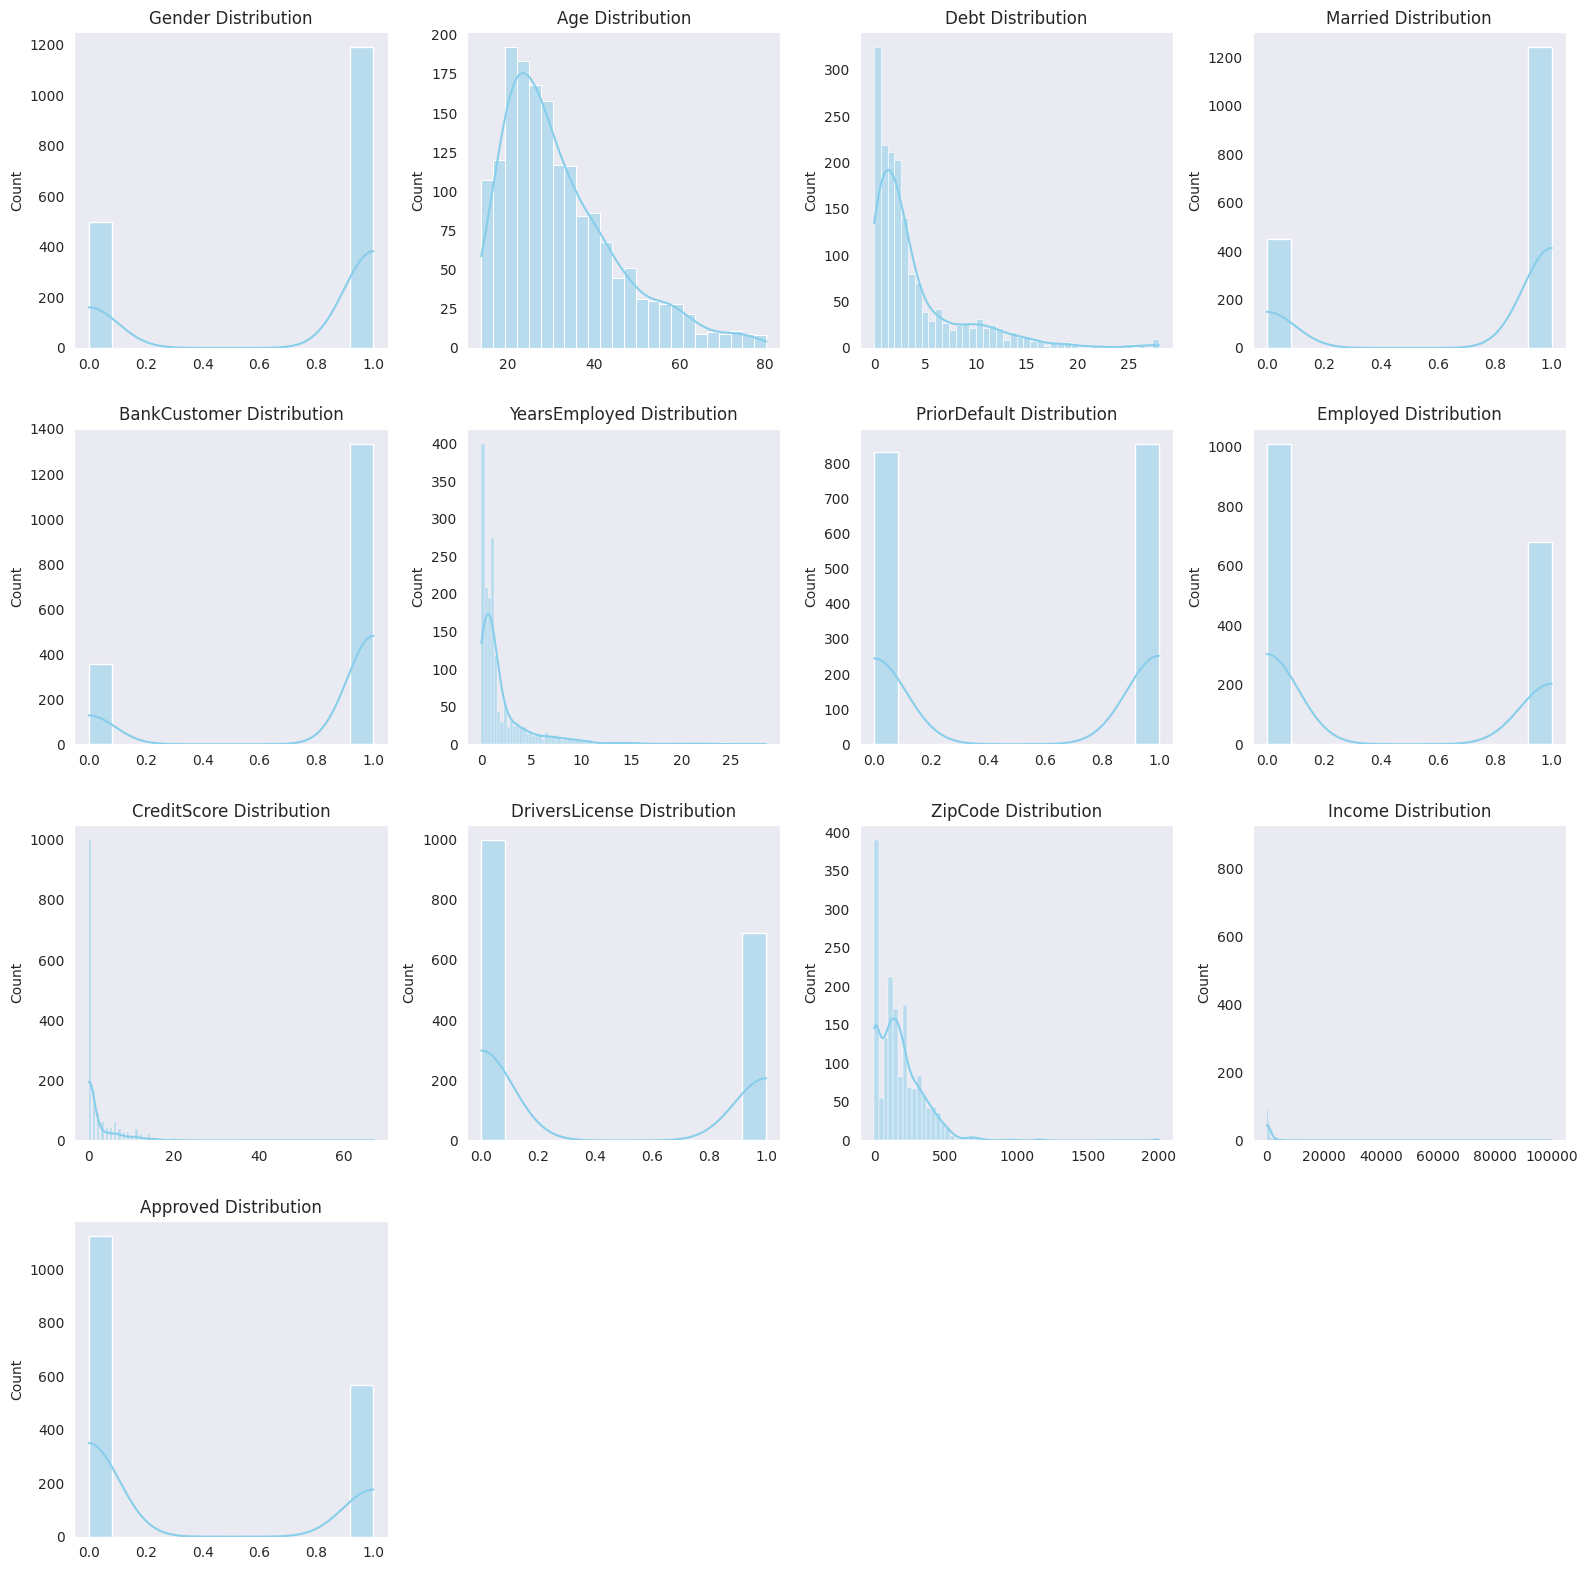

In [73]:
#plotting distributions
plt.figure(figsize=(16,16))
for i,col in enumerate(num_features):
  plot(credit_df,col,i+1)

plt.tight_layout()
plt.show()

Debt,Incmome and Credit Score have been already scaled

In [74]:
#function for pie chart
def pie_plot(col, num, df=credit_df):
    plt.subplot(3,3,num)
    plt.pie(
        df[col].value_counts(),
        labels=df[col].value_counts().index,
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel')
    )
    plt.title(f"{col} Distribution")


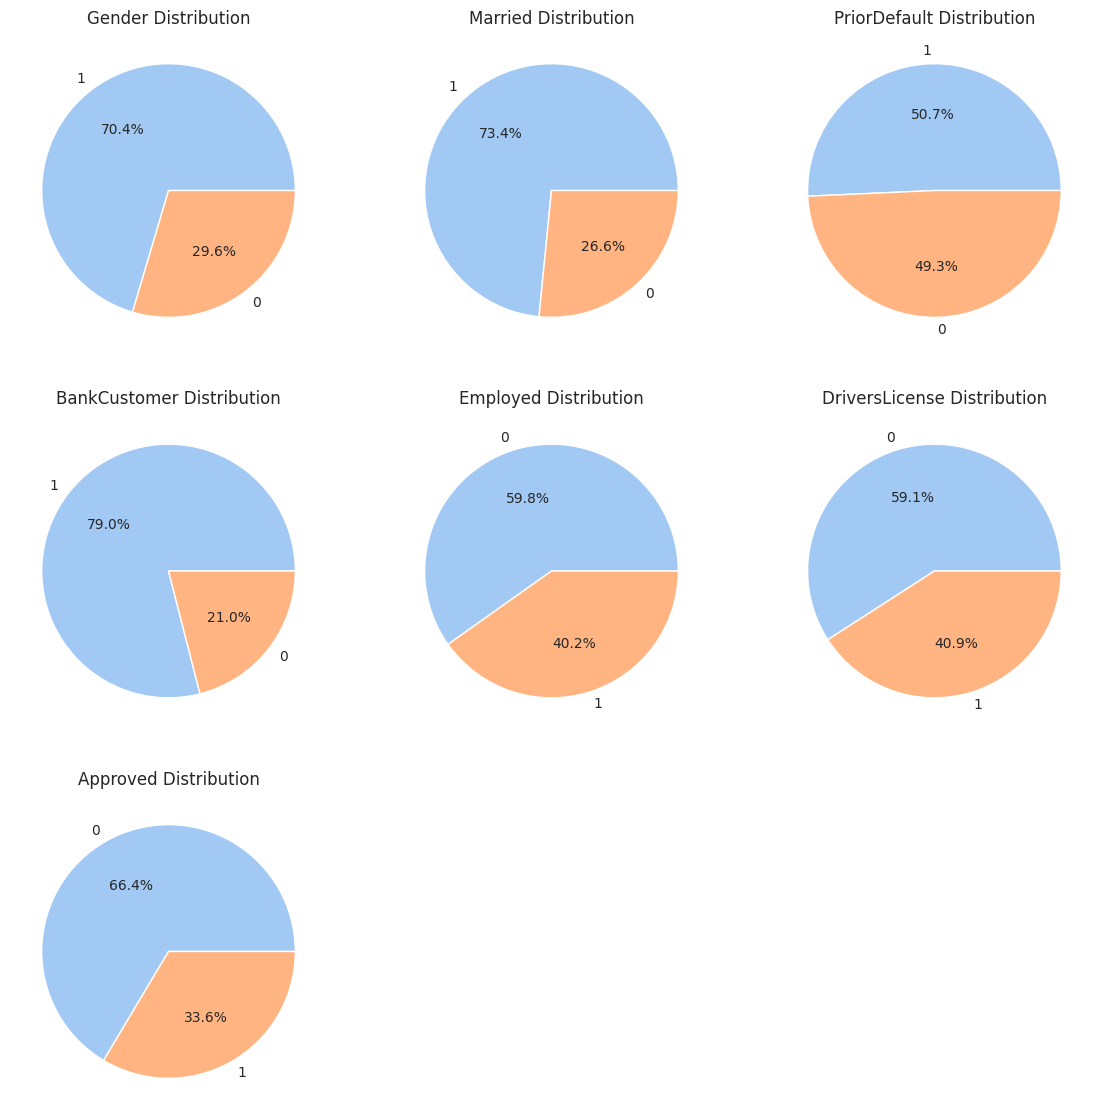

In [75]:
#pie chart for binary distributions
plt.figure(figsize=(14,14))
binary_features = ['Gender','Married','PriorDefault','BankCustomer','Employed','DriversLicense','Approved']
for i,col in enumerate(binary_features):
  pie_plot(col,i+1)
plt.show()

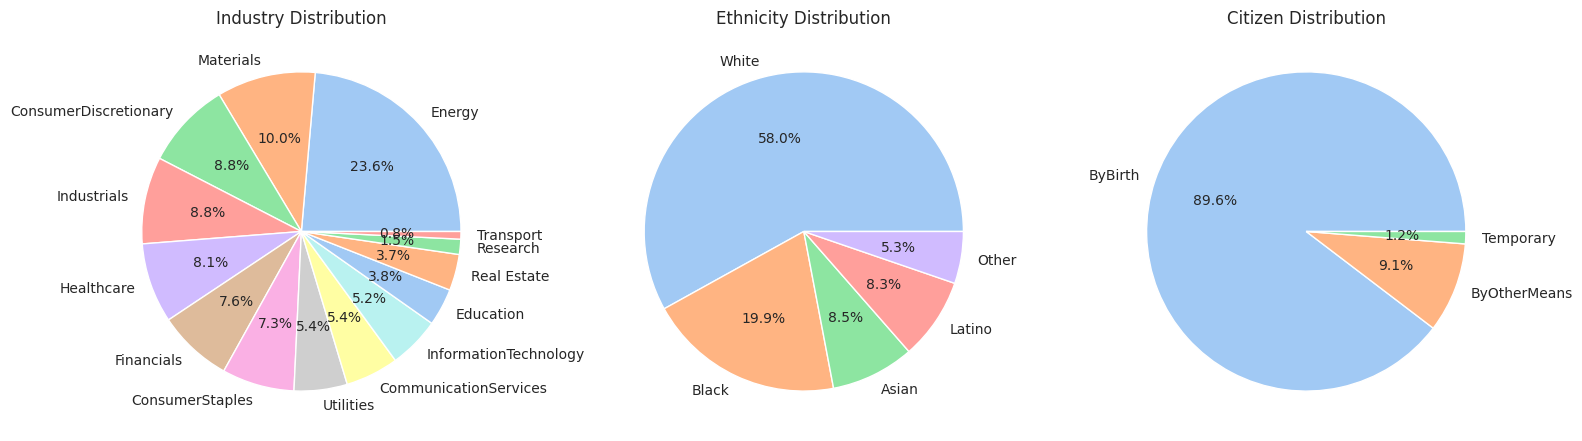

In [76]:
#pie chart for categorical features
plt.figure(figsize=(16,16))
for i,col in enumerate(cat_features):
  pie_plot(col,i+1)

plt.tight_layout()
plt.show()

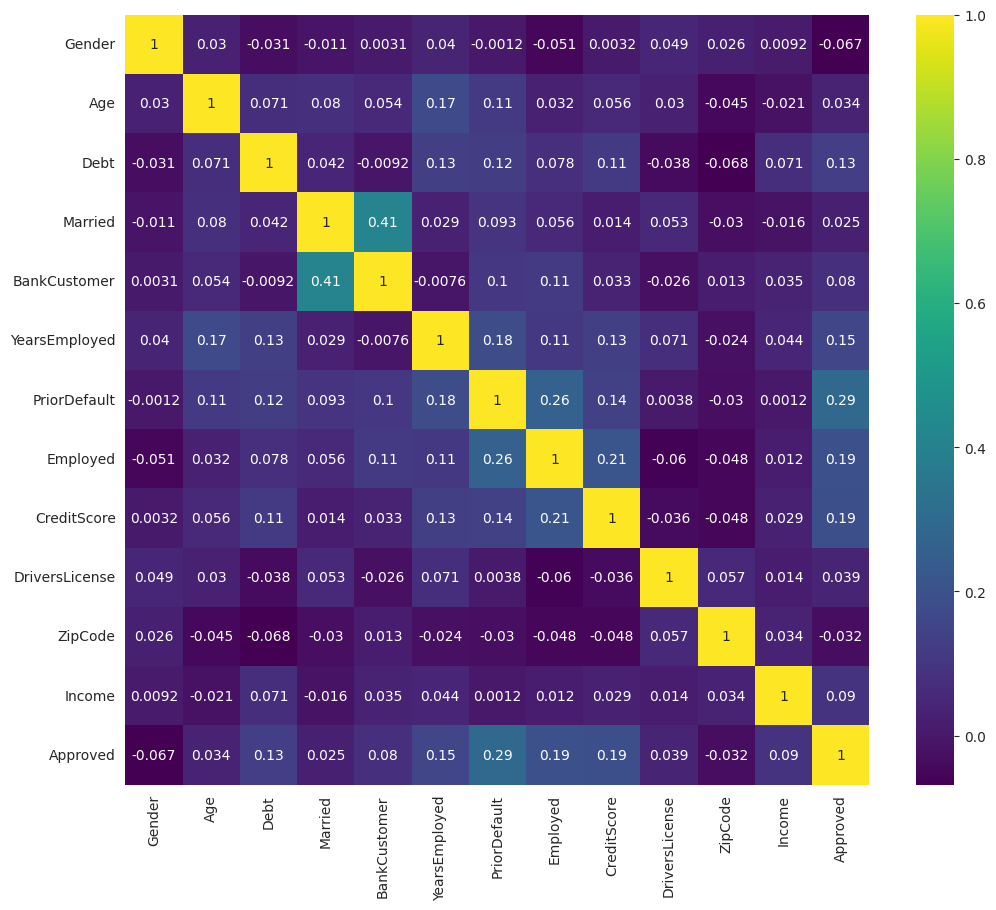

In [77]:
#check collinearity and feature correlation
plt.figure(figsize=(12,10))
numeric_df = credit_df.select_dtypes(exclude='O')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, cmap='viridis',annot=True)
plt.show()

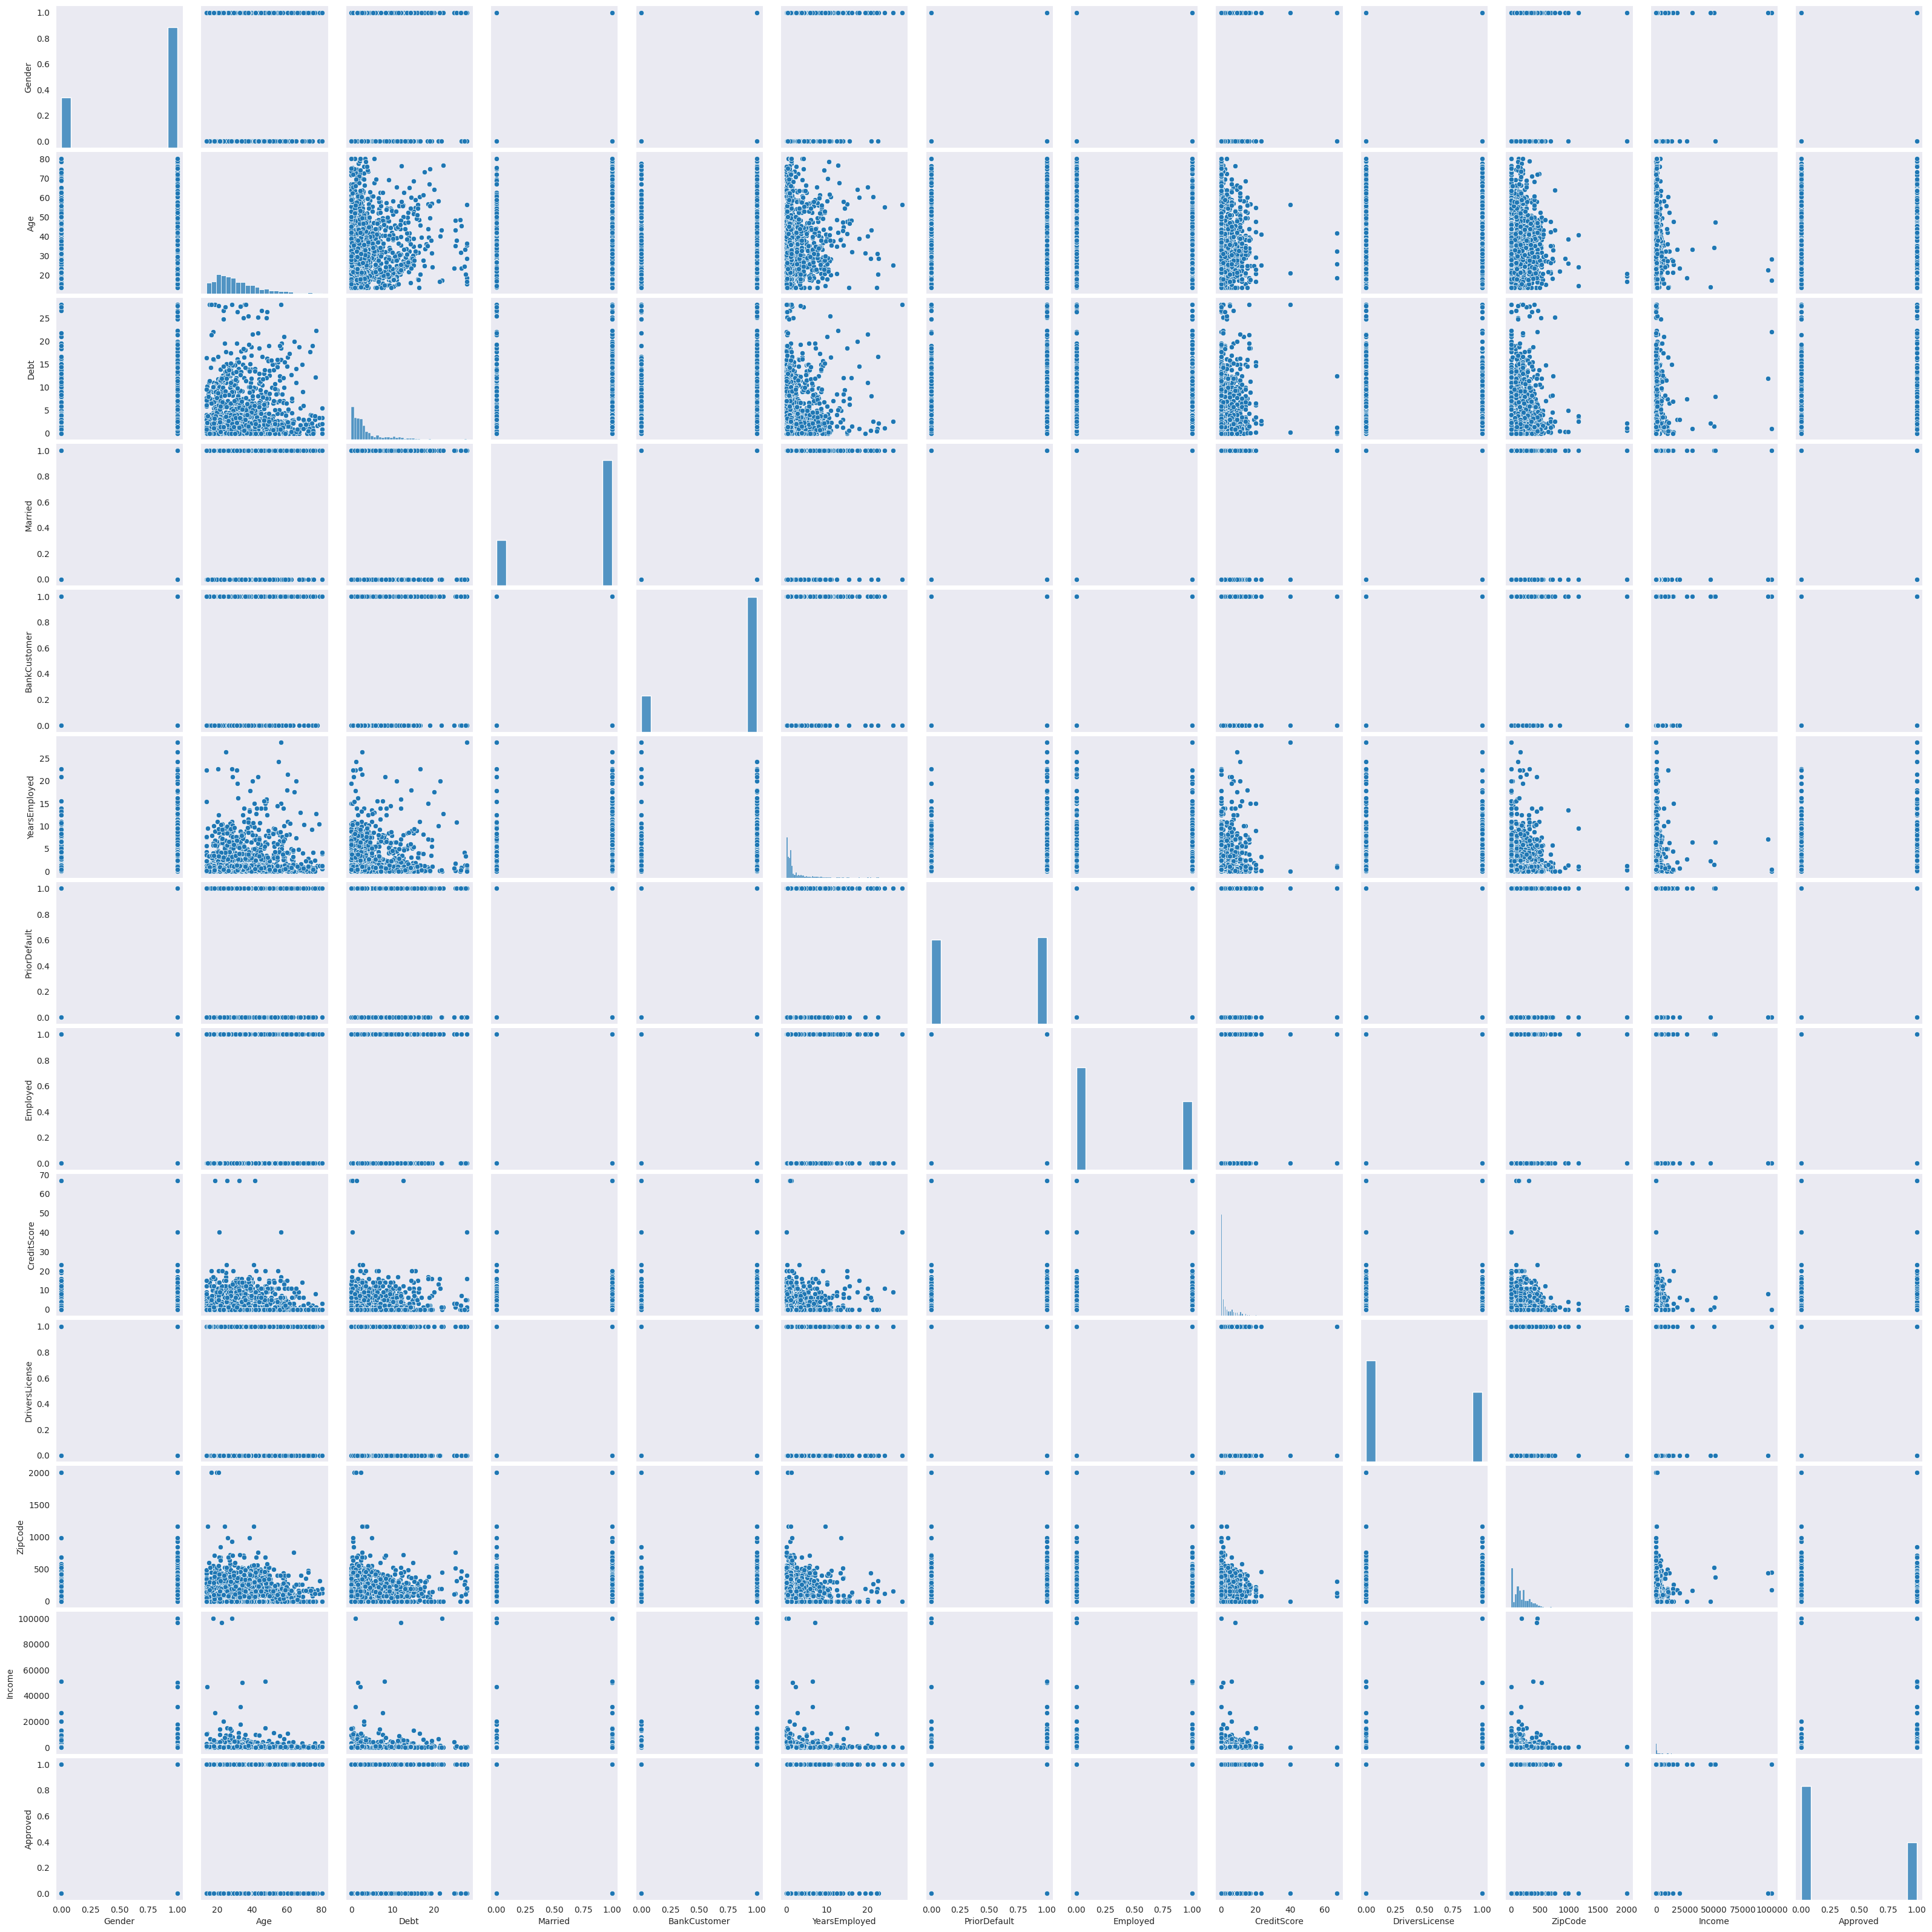

In [78]:
#pairplot
sns.pairplot(data = credit_df)
plt.show()

In [79]:
#dropping less informative features
final_df = credit_df.copy()
final_df = final_df.drop(columns=['Ethnicity','ZipCode'])
final_df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,1,30.83,0.000,1,1,Industrials,1.25,1,1,1,0,ByBirth,0,1
1,0,58.67,4.460,1,1,Materials,3.04,1,1,6,0,ByBirth,560,1
2,0,24.50,0.500,1,1,Materials,1.50,1,0,0,0,ByBirth,824,1
3,1,27.83,1.540,1,1,Industrials,3.75,1,1,5,1,ByBirth,3,1
4,1,20.17,5.625,1,1,Industrials,1.71,1,0,0,0,ByOtherMeans,0,1


In [80]:
final_df.shape

(1690, 14)

In [81]:
#continuous distributions
continuous_features = ['Age','Debt','YearsEmployed','CreditScore','Income']

In [82]:
#function for box plot to analyse outliers
def boxplot(col,num,df=final_df):
  plt.subplot(3,3,num)
  sns.set_style('dark')
  sns.boxplot(data = df,x = col, color='purple')
  plt.title(f'{col} Boxplot Distribution')

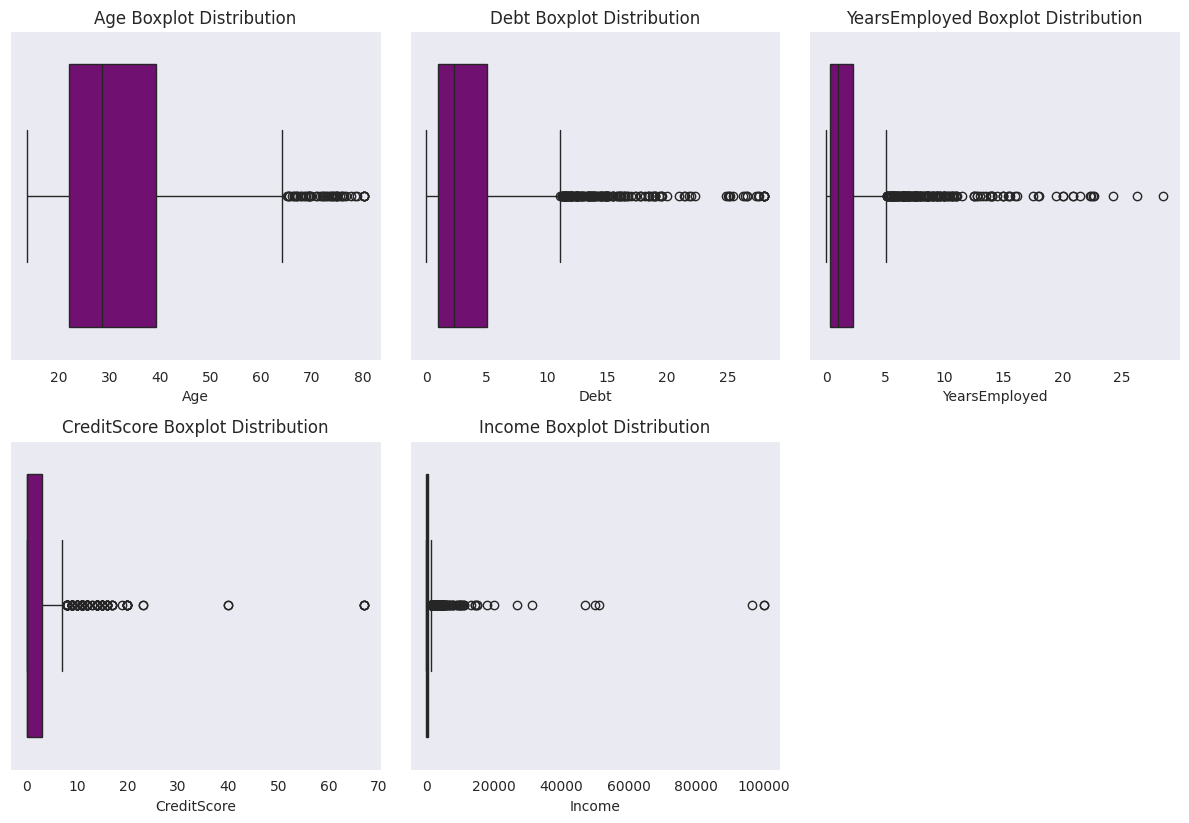

In [83]:
#plotting boxplot for continuous distributions
plt.figure(figsize=(12,12))
for i,col in enumerate(continuous_features):
  boxplot(col,i+1)

plt.tight_layout()
plt.show()

In [84]:
#outlier capping to prevent information loss
def cap_outliers_clip(df, column, lower_percentile=0.01, upper_percentile=0.99):
    q_low = df[column].quantile(lower_percentile)
    q_high = df[column].quantile(upper_percentile)


    df[column] = df[column].clip(lower=q_low, upper=q_high)
    return df

In [85]:
for col in continuous_features:
    final_df = cap_outliers_clip(final_df, col)

In [86]:
#log transformation on highly skewed cols
final_df['CreditScore'] = np.log1p(final_df['CreditScore'])
final_df['Income'] = np.log1p(final_df['Income'])

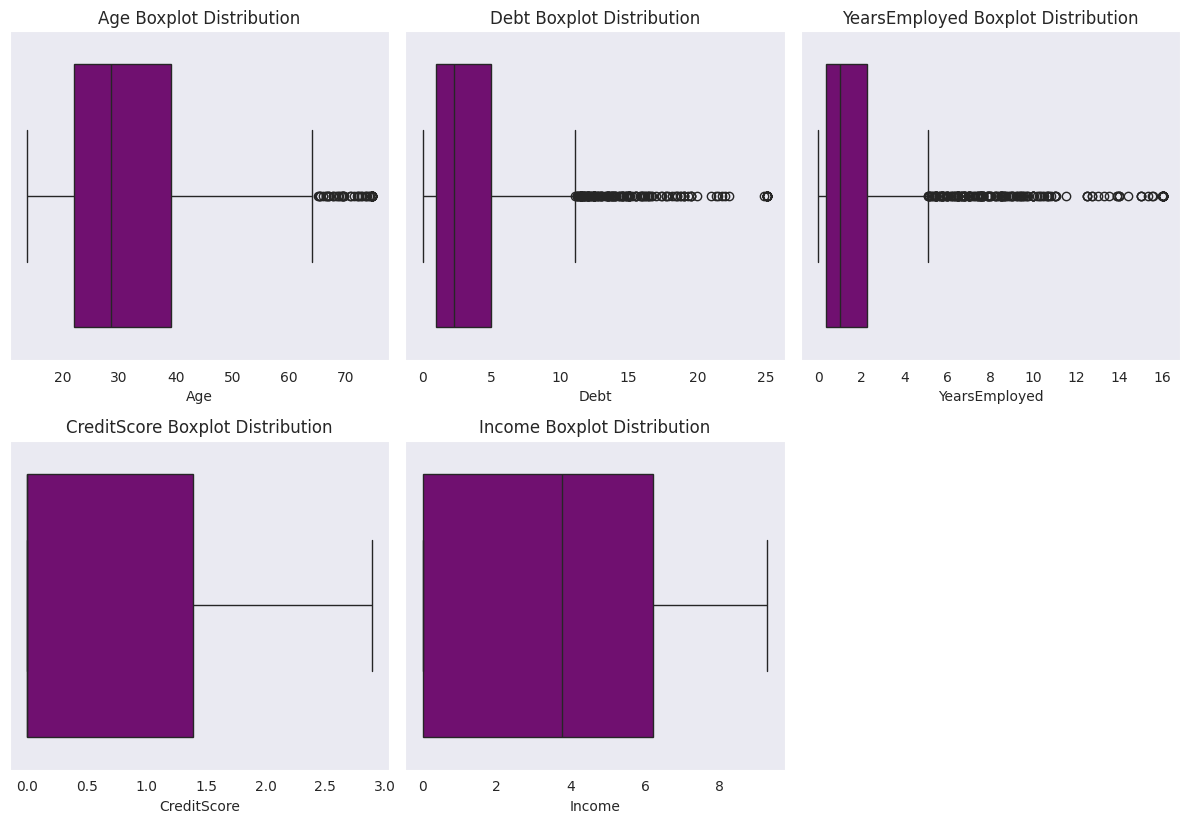

In [87]:
#plotting boxplot for continuous distributions
plt.figure(figsize=(12,12))
for i,col in enumerate(continuous_features):
  boxplot(col,i+1)

plt.tight_layout()
plt.show()

##Data Split

In [88]:
X = final_df.drop(columns = ['Approved'])
y = final_df['Approved']

In [89]:
X.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income
0,1,30.83,0.000,1,1,Industrials,1.25,1,1,0.693147,0,ByBirth,0.000000
1,0,58.67,4.460,1,1,Materials,3.04,1,1,1.945910,0,ByBirth,6.329721
2,0,24.50,0.500,1,1,Materials,1.50,1,0,0.000000,0,ByBirth,6.715383
3,1,27.83,1.540,1,1,Industrials,3.75,1,1,1.791759,1,ByBirth,1.386294
4,1,20.17,5.625,1,1,Industrials,1.71,1,0,0.000000,0,ByOtherMeans,0.000000


In [90]:
#data split for training set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [91]:
X_train.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income
555,1,41.920000,0.420000,1,1,Energy,0.210000,1,1,1.945910,0,ByBirth,6.855409
1387,1,44.613541,0.141976,1,1,Education,3.022585,1,1,0.000000,1,ByBirth,4.882802
914,1,66.520906,3.215226,1,1,Materials,0.221950,0,1,2.302585,0,ByBirth,0.000000
805,0,23.040128,0.238202,0,0,Energy,0.393023,1,1,0.000000,0,ByBirth,0.000000
1100,1,27.937756,0.840944,1,1,Industrials,1.278073,0,1,0.000000,1,ByBirth,5.459586


In [92]:
X_test.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income
872,1,24.859270,0.688868,0,1,ConsumerDiscretionary,4.895843,1,0,0.00000,0,ByBirth,5.153292
177,0,26.080000,8.665000,1,1,ConsumerStaples,1.415000,1,0,0.00000,0,ByBirth,5.017280
907,1,28.304872,1.041969,1,1,Energy,0.468761,0,0,0.00000,1,ByBirth,9.301678
1035,1,72.196572,1.945360,1,1,Real Estate,1.205179,1,1,0.00000,1,ByBirth,0.000000
1288,1,16.787210,2.505491,1,1,Healthcare,7.870262,1,1,1.94591,0,ByBirth,8.091015


In [93]:
#setup preprocessor
#extracting numerical and categorical features
categorical_features = X_train.select_dtypes(include='O').columns.to_list()
binary_features.remove('Approved')

preprocessor = ColumnTransformer(
    transformers=[
        ('bin','passthrough',binary_features),
        ('num',StandardScaler(),continuous_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

#preprocessing X_train and X_test
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [94]:
#saving preprocessor for deployment
joblib.dump(preprocessor,'preprocessor.pkl')

['preprocessor.pkl']

In [95]:
#logistic Regression
lr = LogisticRegression(random_state = 42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold CV
lr_scores = cross_val_score(lr, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", lr_scores)
print("Mean accuracy:", lr_scores.mean())
print("Standard deviation:", lr_scores.std())



Accuracy scores for each fold: [0.76383764 0.72693727 0.72222222 0.73333333 0.72962963]
Mean accuracy: 0.7351920185868526
Standard deviation: 0.014773780269369789


In [96]:
#SVC
svc = SVC(random_state = 42,probability=True)

# Perform 5-fold CV
svc_scores = cross_val_score(svc, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", svc_scores)
print("Mean accuracy:", svc_scores.mean())
print("Standard deviation:", svc_scores.std())

Accuracy scores for each fold: [0.74169742 0.74538745 0.76666667 0.74444444 0.74814815]
Mean accuracy: 0.7492688260215935
Standard deviation: 0.008939873828155186


In [97]:
#KNN
knn = KNeighborsClassifier()

# Perform 5-fold CV
knn_scores = cross_val_score(knn, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", knn_scores)
print("Mean accuracy:", knn_scores.mean())
print("Standard deviation:", knn_scores.std())

Accuracy scores for each fold: [0.73431734 0.74907749 0.71481481 0.70740741 0.72962963]
Mean accuracy: 0.7270493371600383
Standard deviation: 0.014698369390804539


In [98]:
#Naive Bayes
nb = GaussianNB()

# Perform 5-fold CV
nb_scores = cross_val_score(nb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", nb_scores)
print("Mean accuracy:", nb_scores.mean())
print("Standard deviation:", nb_scores.std())

Accuracy scores for each fold: [0.70848708 0.69372694 0.62962963 0.64074074 0.67407407]
Mean accuracy: 0.6693316933169332
Standard deviation: 0.030147833158387906


In [99]:
#RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold CV
rf_scores = cross_val_score(rf, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", rf_scores)
print("Mean accuracy:", rf_scores.mean())
print("Standard deviation:", rf_scores.std())

Accuracy scores for each fold: [0.7601476  0.76383764 0.77037037 0.75555556 0.73333333]
Mean accuracy: 0.7566488998223315
Standard deviation: 0.01262543996579359


In [100]:
#GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=22)

# Perform 5-fold CV
gb_scores = cross_val_score(gb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", gb_scores)
print("Mean accuracy:", gb_scores.mean())
print("Standard deviation:", gb_scores.std())

Accuracy scores for each fold: [0.7601476  0.75276753 0.74814815 0.76296296 0.75185185]
Mean accuracy: 0.7551756184228509
Standard deviation: 0.0055062694121562165


In [101]:
#XGBClassifier
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    objective='binary:logistic'
)

# Perform 5-fold CV
xgb_scores = cross_val_score(xgb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", xgb_scores)
print("Mean accuracy:", xgb_scores.mean())
print("Standard deviation:", xgb_scores.std())

Accuracy scores for each fold: [0.75276753 0.70848708 0.75185185 0.72962963 0.73333333]
Mean accuracy: 0.7352138854721881
Standard deviation: 0.016333980163393956


LogisticRegression, SVC, Random Forests perform well

##Evaluation on Testing Set

In [102]:
#logistic regression
lr.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_lr = lr.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_lr = lr.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_lr = classification_report(y_train,ypred_train_lr)
print("----- Classification report for Training Set -----")
print(clf_report_train_lr)

#classification report for testing set
clf_report_test_lr = classification_report(y_test,ypred_test_lr)
print("----- Classification report for Testing Set -----")
print(clf_report_test_lr)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       898
           1       0.69      0.46      0.55       454

    accuracy                           0.75      1352
   macro avg       0.73      0.68      0.69      1352
weighted avg       0.74      0.75      0.73      1352

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       225
           1       0.59      0.38      0.46       113

    accuracy                           0.70       338
   macro avg       0.66      0.62      0.63       338
weighted avg       0.69      0.70      0.68       338



In [103]:
# Support Vector Classifier
svc.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_svc = svc.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_svc = svc.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_svc = classification_report(y_train,ypred_train_svc)
print("----- Classification report for Training Set -----")
print(clf_report_train_svc)

#classification report for testing set
clf_report_test_svc = classification_report(y_test,ypred_test_svc)
print("----- Classification report for Testing Set -----")
print(clf_report_test_svc)


----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       898
           1       0.85      0.44      0.58       454

    accuracy                           0.79      1352
   macro avg       0.81      0.70      0.72      1352
weighted avg       0.80      0.79      0.76      1352

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.71      0.92      0.81       225
           1       0.64      0.27      0.38       113

    accuracy                           0.70       338
   macro avg       0.68      0.59      0.59       338
weighted avg       0.69      0.70      0.66       338



In [104]:
#Random Forest Classifier
rf.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_rf = rf.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_rf = rf.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_rf = classification_report(y_train,ypred_train_rf)
print("----- Classification report for Training Set -----")
print(clf_report_train_rf)

#classification report for testing set
clf_report_test_rf = classification_report(y_test,ypred_test_rf)
print("----- Classification report for Testing Set -----")
print(clf_report_test_rf)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       898
           1       1.00      1.00      1.00       454

    accuracy                           1.00      1352
   macro avg       1.00      1.00      1.00      1352
weighted avg       1.00      1.00      1.00      1352

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       225
           1       0.59      0.34      0.43       113

    accuracy                           0.70       338
   macro avg       0.66      0.61      0.61       338
weighted avg       0.68      0.70      0.67       338



SVC Performs the Best

##Confusion Matrix, ROC_AUC curve and Evaluation metrics

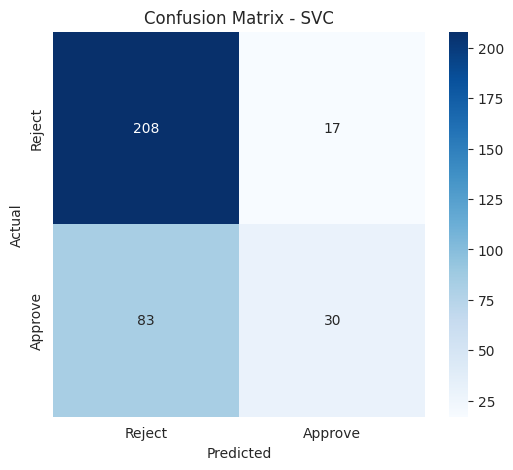

In [105]:
#confusion matrix
cm = confusion_matrix(y_test,ypred_test_svc)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Reject','Approve'], yticklabels=['Reject','Approve'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC')
plt.show()

In [106]:
#Classification Report
print("------ Classification Report SVC ------")
print(clf_report_test_svc)

------ Classification Report SVC ------
              precision    recall  f1-score   support

           0       0.71      0.92      0.81       225
           1       0.64      0.27      0.38       113

    accuracy                           0.70       338
   macro avg       0.68      0.59      0.59       338
weighted avg       0.69      0.70      0.66       338



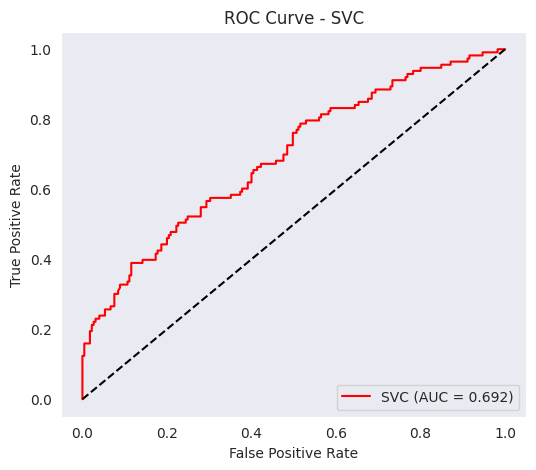

In [107]:
#ROC-AUC curve
yprob_svc = svc.predict_proba(X_test_preprocessed)[:,1]
auc_score = roc_auc_score(y_test, yprob_svc)
fpr, tpr, thresholds = roc_curve(y_test, yprob_svc)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVC (AUC = {auc_score:.3f})",color='red')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend(loc='lower right')
plt.show()

In [108]:
#saving model
joblib.dump(svc,'model.pkl')

['model.pkl']